## CuLSH

In [4]:
#!pip install pycuda
#https://pypi.org/project/pycuda/
#https://documen.tician.de/pycuda/
#https://stackoverflow.com/questions/68256354/cuda-c-library-in-python-transfer-gpu-memory-data-from-one-functions-to-ower
#https://forums.developer.nvidia.com/t/fast-memcpy-micro-benchmarking-cuda-python-wrapper-multi-gpu-seg-fault/274712

In [5]:
# backup
#https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_Deep_Supervised_Hashing_CVPR_2016_paper.pdf
#https://github.com/thuml/HashNet/tree/master
#https://github.com/flyingpot/pytorch_deephash
#https://github.com/weixu000/DSH-pytorch/blob/master/utils.py
#https://github.com/swuxyj/DeepHash-pytorch?tab=readme-ov-file
#https://github.com/dansuh17/deep-supervised-hashing
#https://github.com/inducer/pycuda/blob/main/examples/demo_elementwise.py

In [6]:
#Hash on gpu
#https://docs.rapids.ai/api/libcudf/stable/group__nvtext__minhash


#https://on-demand.gputechconf.com/gtc/2015/presentation/S5796-Peter-Andreas-Entschev.pdf
#https://www.hackerfactor.com/blog/index.php?/archives/432-Looks-Like-It.html
#http://www.phash.org/


In [7]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy

from pycuda.compiler import SourceModule
mod = SourceModule("""
__global__ void multiply_them(float *dest, float *a, float *b)
{
  const int i = threadIdx.x;
  dest[i] = a[i] * b[i];
}
""")

multiply_them = mod.get_function("multiply_them")

a = numpy.random.randn(20).astype(numpy.float32)
b = numpy.random.randn(20).astype(numpy.float32)


print(a)
print(b)
dest = numpy.zeros_like(a)
multiply_them(
        drv.Out(dest), drv.In(a), drv.In(b),
        block=(400,1,1), grid=(1,1))

print(dest-a*b)

[ 0.06422433 -0.4624154  -0.51955783  0.05261678 -0.8578046   1.7897247
 -0.23895487  0.22889704 -0.24606426 -0.7221408  -0.5455345   1.2819496
  0.5091082   0.570859    1.8676077   0.3823664   1.0060452  -0.375391
 -0.43617663 -0.07884419]
[-0.04441341 -0.33937138  0.44411165  1.0660666  -1.1826115  -1.9595382
 -0.13691556 -0.4772159   0.46913752 -1.2656679  -0.13791351  1.408592
 -0.46110204  0.9645728  -1.242451    1.0980163   0.3914974  -1.2721286
  0.47762454 -0.05274221]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### 1. Load Cifar

In [8]:
import os
import _pickle as cPickle
import numpy as np

PATH = "../data/cifar-10-batches-py/"

In [9]:
def load_batch():
    file = 'data_batch_1'

    f = open(PATH+file, 'rb')
    dict_ = cPickle.load(f, encoding='latin1')
    images = dict_['data']
    #images = np.reshape(images, (10000, 3, 32, 32))
    labels = dict_['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

In [10]:
def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

def print_classes(label_names):
    for i in range(0, 10):
        print(str(i) + " : " + label_names[i] + "  ")

label_names = load_classes()
print_classes(label_names)

0 : airplane  
1 : automobile  
2 : bird  
3 : cat  
4 : deer  
5 : dog  
6 : frog  
7 : horse  
8 : ship  
9 : truck  


In [11]:
images, labels = load_batch()

In [12]:
special_image = images[0]

In [13]:
special_image2 = special_image
special_image = np.reshape(special_image, (3, 32, 32)).T

In [14]:
special_image.shape

(32, 32, 3)

### 1.2 Load ImageNet

In [15]:
#https://patrykchrabaszcz.github.io/Imagenet32/
# 1 281 167 training images from 1000 classes and 50 000 validation images with 50 images per class.

In [16]:
!pip install git+https://github.com/nottombrown/imagenet_stubs

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-bjfvrgmx
  Running command git clone --filter=blob:none --quiet https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-bjfvrgmx
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py) ... done


In [17]:
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name
print(label_to_name(0))

tench, Tinca tinca


In [18]:
IMAGENET_PATH = "../data/Imagenet32_train/"

In [19]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

In [20]:
def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    dict_ = unpickle(data_file + str(idx))

    images = dict_['data']
    labels = dict_['labels']

    ## images_without_mean = dict_['mean']   ??? check is there are better results or not

    return images, labels

In [21]:
images2, labels2 = load_databatch(IMAGENET_PATH, 1)

In [22]:
images2.shape

(128116, 3072)

In [23]:
len(labels2)

128116

In [24]:
HN_example_image = np.reshape(images2[1], (3, 32, 32)).T

In [25]:
HN_exmaple_label = label_to_name(labels2[1])

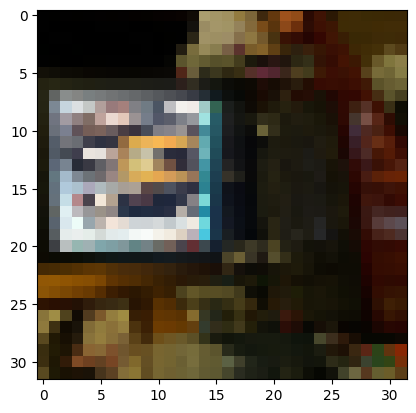

In [26]:
from matplotlib import pyplot as plt
plt.imshow(HN_example_image, interpolation='nearest')
plt.show()

In [27]:
HN_exmaple_label

'espresso maker'

### 2. Preprocesing 

In [28]:
def scale_image_down_and_gray_1d(image, new_rows, new_cols):

    pixels = 1024
    newPixels = new_rows * new_cols;
    factor = pixels / newPixels;

    new_image = np.empty(newPixels, dtype=numpy.uint8)

    for idx in range(newPixels):
        pixelToTake = int(idx*factor)
        
        pixel = 0.2989 * image[pixelToTake] \
              + 0.5870 * image[1024+pixelToTake] \
              + 0.1140 * image[2048+pixelToTake]
        
        new_image[idx] = pixel
        
    return new_image

In [29]:
def scale_image_down_and_gray(np_image, new_rows, new_columns):
    
    columns = np_image.shape[0]
    rows = np_image.shape[1]

    factor_columns = columns / new_columns
    factor_rows = rows / new_rows

    new_image = np.empty([new_columns, new_rows, 1], dtype=numpy.uint8)

    print(new_image.shape)
    
    for row in range(new_rows):
        for col in range(new_columns):
            new_row = int(row * factor_rows)
            new_col = int(col * factor_columns)

            pixel = 0.2989 * np_image[new_col][new_row][0] \
                  + 0.5870 * np_image[new_col][new_row][1] \
                  + 0.1140 * np_image[new_col][new_row][2]
            
            new_image[col][row][0] = pixel
    return new_image

def scale_image_up(np_image, new_width, new_height):
    pass

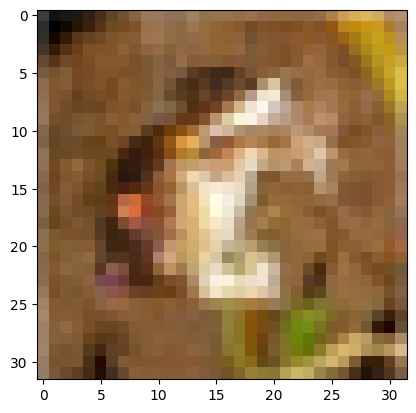

In [30]:
from matplotlib import pyplot as plt
plt.imshow(special_image, interpolation='nearest')
plt.show()

In [31]:
down_scaled_image = scale_image_down_and_gray(special_image, 9, 8)

(8, 9, 1)


In [32]:
down_scaled_image.shape

(8, 9, 1)

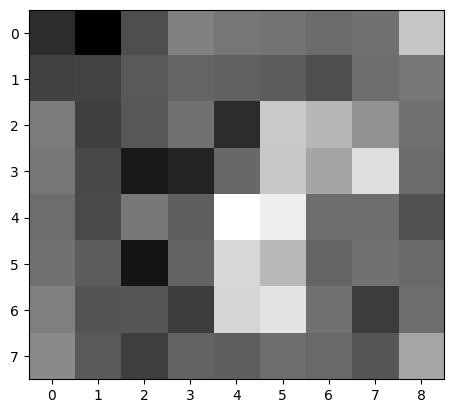

In [33]:
plt.imshow(down_scaled_image, cmap='gray')
plt.show()

In [34]:
down_scaled_image.shape

(8, 9, 1)

In [35]:
def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)

### own kernel to image

In [36]:
# article - https://medium.com/@sim30217/bilinear-interpolation-e41fc8b63fb4
# Nearest Neighbor - which can result in visible artifacts or jagged edges.
# Billinar 
# Gaussian - https://medium.com/@rohit-krishna/coding-gaussian-blur-operation-from-scratch-in-python-f5a9af0a0c0f
# SPline ??? or other common kernel 
#http://forum.doom9.org/archive/index.php/t-145210.html

### Create Hash

In [37]:
down_scaled_image.shape

(8, 9, 1)

In [38]:
def comp_difference(image_2d):
    sequence = ""

    rows = image_2d.shape[0]
    cols = image_2d.shape[1]

    print( rows, cols)
    for row in range(rows):
        for col in range(1, cols):
            if image_2d[row][col-1] < image_2d[row][col]:
                sequence += '1'
            else:
                sequence += '0'

    print(sequence)

In [39]:
comp_difference(down_scaled_image) # 63E3683A50325929

8 9
0110001111100011011010000011101001010000001100100101100100101001


In [40]:
diff = down_scaled_image[:, 1:] > down_scaled_image[:, :-1] # 63E3683A50325929

In [41]:
print(diff.flatten().astype(int))

[0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0
 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1]


#### GPU-kernel convertion

In [42]:
#https://stackoverflow.com/questions/5029920/how-to-use-2d-arrays-in-cuda
#https://github.com/royinx/CUDA_Resize

In [43]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy

from pycuda.compiler import SourceModule

In [44]:
'''
mod = SourceModule("""
__global__ void ResizeAndGrayOneImage2D(float imageR[32][32], float hash[9][9], int rows, int columns, int new_rows, int new_cols)
{
    int row = blockDim.y * blockIdx.y + threadIdx.y;
    int col = blockDim.x * blockIdx.x + threadIdx.x;
    
    if( row >= new_rows || col >= new_cols ) return;

    float factor_columns = columns / new_cols;
    float factor_rows = rows / new_rows;

    int new_row = row * factor_rows;
    int new_col = col * factor_columns;

    auto pixel = 0.2989 * imageR[new_col][new_row] + 0.5870 * imageR[new_col][new_row] + 0.1140 * imageR[new_col][new_row];
               
    hash[col][row] = pixel;
}

""")

your_kernel_2D = mod.get_function("ResizeAndGrayOneImage2D")

'''

'\nmod = SourceModule("""\n__global__ void ResizeAndGrayOneImage2D(float imageR[32][32], float hash[9][9], int rows, int columns, int new_rows, int new_cols)\n{\n    int row = blockDim.y * blockIdx.y + threadIdx.y;\n    int col = blockDim.x * blockIdx.x + threadIdx.x;\n    \n    if( row >= new_rows || col >= new_cols ) return;\n\n    float factor_columns = columns / new_cols;\n    float factor_rows = rows / new_rows;\n\n    int new_row = row * factor_rows;\n    int new_col = col * factor_columns;\n\n    auto pixel = 0.2989 * imageR[new_col][new_row] + 0.5870 * imageR[new_col][new_row] + 0.1140 * imageR[new_col][new_row];\n               \n    hash[col][row] = pixel;\n}\n\n""")\n\nyour_kernel_2D = mod.get_function("ResizeAndGrayOneImage2D")\n\n'

In [45]:
### PyCUDA error - working properly only for floats
### LogicError - not know why, po prostu tak sobie wyskoczył

mod = SourceModule("""

__global__ void ResizeAndGrayOneImage(float* image, float* hash, int pixels, int new_rows, int new_cols)
{
    extern __shared__ int pixelsValues[72];

    int idx         = threadIdx.x + blockIdx.x * blockDim.x;
    float newPixels = new_rows * new_cols;
    
    if (idx >= newPixels) return;

    float factor           = pixels / newPixels;
    const auto pixelToTake = (int)(idx*factor);


    auto pixel = 0.2989 * image[pixelToTake] + 0.5870 * image[1024+pixelToTake] + 0.1140 * image[2048+pixelToTake];

    pixelsValues[idx] = pixel;

    __syncthreads();
    
    if(idx == 0) return;

    pixelsValues[idx-1] < pixelsValues[idx] ? hash[idx-1] = 1 : hash[idx-1] = 0;    
}

""")

your_kernel = mod.get_function("ResizeAndGrayOneImage")

In [107]:
def arrayToHexString(imageHashArray):
    hash_ = ""

    tmp_imageHashArray = imageHashArray.astype(numpy.uint8)
    
    for i in range(0, imageHashArray.shape[0], 4):
        tmp = str(tmp_imageHashArray[i]) + str(tmp_imageHashArray[i+1]) + str(tmp_imageHashArray[i+2]) + str(tmp_imageHashArray[i+3])
        
        hash_ += hex(int(tmp, 2))[2:]

    return hash_

In [108]:
special_image2.shape

(3072,)

In [109]:
b = numpy.zeros(72).astype(numpy.float32)
b.dtype

dtype('float32')

In [110]:
# max threads = 1024
# max blocks = 65535

your_kernel(drv.In(special_image2.astype(numpy.float32)), drv.Out(b), np.int32(1024) , np.int32(8) , np.int32(9), 
            block=(72,1,1))

In [111]:
arrayToHexString(b) # 63E3683A50325929

'dd599776ab5126b2b4'

In [52]:
b_respace

array([[ 61.2111, 111.5903, 135.3922,  76.9914,  86.7579,  89.6589,
        101.7779,  71.8564,  84.2573],
       [ 36.123 ,  86.3989,  73.7637,  88.7577, 107.204 ,  83.1389,
         56.7852, 104.827 , 146.2531],
       [107.4013,  32.2266,  95.6753,  65.541 ,  70.8179, 107.4506,
        140.1145, 103.5605, 107.6742],
       [119.7528, 176.1789, 101.1416, 117.2405, 126.0529,  75.8605,
        210.8225, 108.4523, 249.1095],
       [121.0471, 193.898 , 120.317 , 151.7065, 205.9307, 159.6331,
        195.1014,  99.7997, 119.2339],
       [111.3147,  94.0992,  92.1271, 141.0559, 115.0539, 104.5434,
        111.4026, 106.8161, 101.4853],
       [115.7811, 169.4058,  94.6247, 128.9154, 112.0111, 113.441 ,
        118.0815, 114.2809, 103.5651],
       [182.966 ,  97.2129, 157.7524, 102.6361, 108.9298, 135.7767,
         93.4215, 151.2942, 123.0021]], dtype=float32)

In [53]:
other_image = scale_image_down_and_gray_1d(special_image2, 9, 8)

In [54]:
other_image_reshaped = np.reshape(other_image, (8, 9))
other_image_reshaped

array([[ 61, 111, 135,  76,  86,  89, 101,  71,  84],
       [ 36,  86,  73,  88, 107,  83,  56, 104, 146],
       [107,  32,  95,  65,  70, 107, 140, 103, 107],
       [119, 176, 101, 117, 126,  75, 210, 108, 249],
       [121, 193, 120, 151, 205, 159, 195,  99, 119],
       [111,  94,  92, 141, 115, 104, 111, 106, 101],
       [115, 169,  94, 128, 112, 113, 118, 114, 103],
       [182,  97, 157, 102, 108, 135,  93, 151, 123]], dtype=uint8)

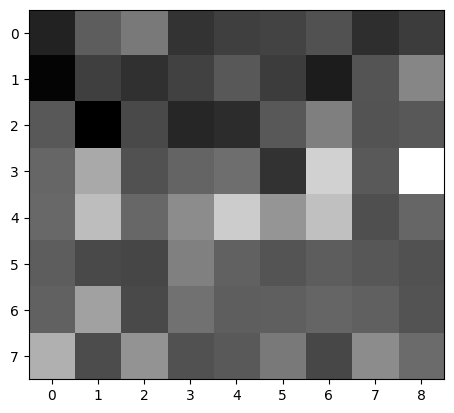

In [55]:
plt.imshow(other_image_reshaped, cmap='gray')
plt.show()

In [63]:
#comp_difference() # 63E3683A50325929

In [57]:
special_image3 = special_image2[:1024]

In [58]:
special_image3.shape

(1024,)

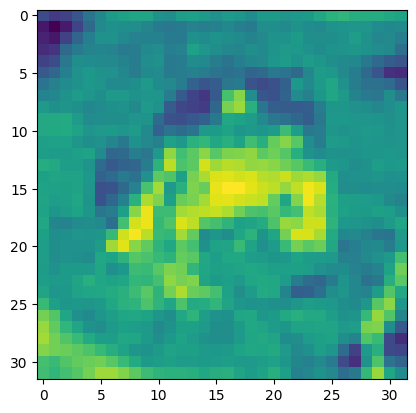

In [59]:
plt.imshow(np.reshape(special_image3, (32, 32)))
plt.show()

### 2D

In [13]:
in_image = special_image2.reshape([3,32,32]).astype(numpy.float32).T
in_image.shape
in_image[:,:,0].shape

(32, 32)

In [14]:
out_image = numpy.zeros([8,9]).astype(numpy.float32)
out_image.shape

(8, 9)

In [15]:
# max threads = 1024
# max blocks = 65535

your_kernel_2D(drv.In(in_image[:,:,0]), drv.Out(out_image), np.int32(32), np.int32(32) , np.int32(8) , np.int32(9), 
            block=(8,9,1), grid=(1,1))

#np.set_printoptions(suppress = False)
out_image_res = np.reshape(out_image, (8, 9))
out_image_res.shape

LogicError: cuCtxSynchronize failed: an illegal memory access was encountered

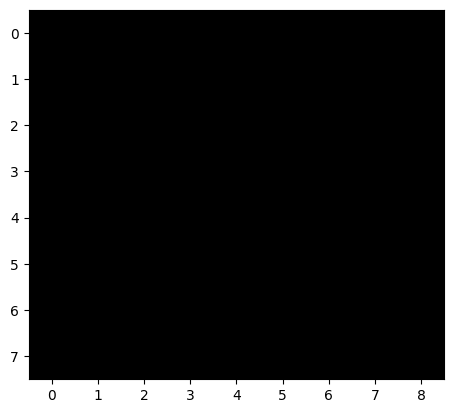

In [67]:
plt.imshow(out_image_res, cmap='gray')
plt.show()